In [2]:
import pandas as pd

# Cargar dataset directamente desde la URL
url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"
df = pd.read_csv(url)

# Ver primeras filas
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocesamiento:
def preprocess_url(url):
    if pd.isnull(url):  # manejar valores nulos
        return ""
    url = url.lower()
    tokens = re.split(r'\W+', url)
    return ' '.join(tokens)

print("Preprocesando URLs...")
df['processed_url'] = df['url'].apply(preprocess_url)
X = df['processed_url']
y = df['is_spam'].astype(int)  # Convertimos True/False a 1/0


Preprocesando URLs...


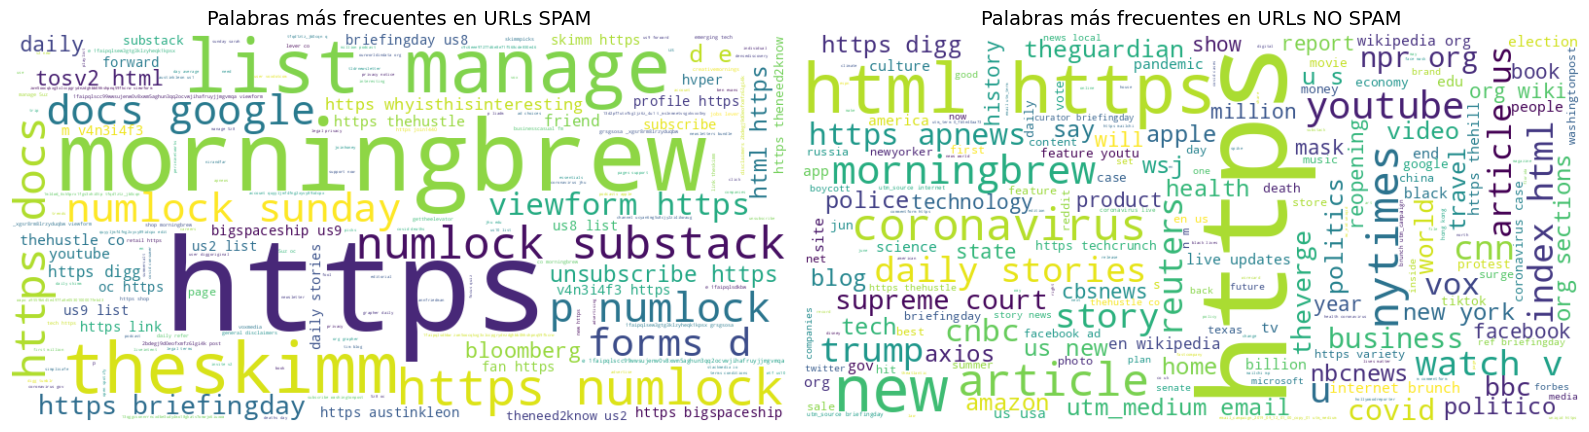

In [5]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Asegúrate de tener la columna 'processed_url'
# Si no la tienes, aplica de nuevo el preprocesamiento
df['processed_url'] = df['url'].apply(preprocess_url)

# Filtra solo SPAM o NO SPAM
spam_text = ' '.join(df[df['is_spam'] == True]['processed_url'])
not_spam_text = ' '.join(df[df['is_spam'] == False]['processed_url'])

# Generar la nube de palabras
spam_wc = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
not_spam_wc = WordCloud(width=800, height=400, background_color='white').generate(not_spam_text)

# Mostrar ambas
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(spam_wc, interpolation='bilinear')
ax[0].set_title("Palabras más frecuentes en URLs SPAM", fontsize=14)
ax[0].axis('off')

ax[1].imshow(not_spam_wc, interpolation='bilinear')
ax[1].set_title("Palabras más frecuentes en URLs NO SPAM", fontsize=14)
ax[1].axis('off')

plt.tight_layout()
plt.show()


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorización por caracteres: ideal para URLs
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5))
X_vectorized = vectorizer.fit_transform(X)


In [7]:
# División train/test --
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [8]:
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Entrenar modelo SVM básico 
print("Entrenando modelo SVM inicial...")
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print("Resultados SVM inicial:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Entrenando modelo SVM inicial...
Resultados SVM inicial:
[[453   2]
 [ 18 127]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       455
           1       0.98      0.88      0.93       145

    accuracy                           0.97       600
   macro avg       0.97      0.94      0.95       600
weighted avg       0.97      0.97      0.97       600



**Matriz de confusión:**

    453 verdaderos negativos (ham correctamente clasificados)

    127 verdaderos positivos (spam correctamente clasificados)

    2 falsos positivos (ham clasificados como spam)

    18 falsos negativos (spam clasificados como ham)

**Métricas clave:**

    Accuracy: 0.97 → El modelo acierta el 97% de las veces.

    Precision clase spam (1): 0.98 → De todos los que predijo como spam, el 98% lo eran realmente.

    Recall clase spam (1): 0.88 → Detecta el 88% de los enlaces spam reales.

    F1-score clase spam (1): 0.93 → Buen equilibrio entre precisión y recall.

In [11]:
# Optimización con Grid Search --
print("Optimizando modelo con GridSearchCV...")
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Mejores parámetros:", grid.best_params_)
y_pred_opt = best_model.predict(X_test)
print("Resultados modelo optimizado:")
print(confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt))

Optimizando modelo con GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Resultados modelo optimizado:
[[451   4]
 [ 12 133]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       455
           1       0.97      0.92      0.94       145

    accuracy                           0.97       600
   macro avg       0.97      0.95      0.96       600
weighted avg       0.97      0.97      0.97       600



**Mejoras respecto al modelo inicial:**

    El recall del spam subió del 0.88 al 0.92, lo que significa que ahora detectas más enlaces spam.

    El f1-score del spam subió a 0.94 → excelente equilibrio entre precisión y recall.

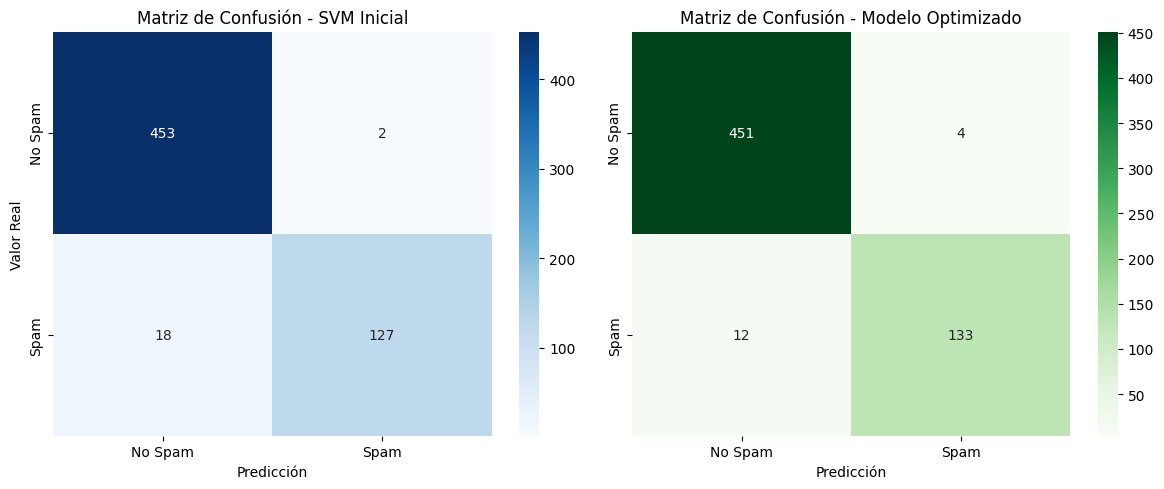

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Etiquetas
labels = ['No Spam', 'Spam']

# Calcular ambas matrices de confusión
cm_inicial = confusion_matrix(y_test, y_pred)
cm_opt = confusion_matrix(y_test, y_pred_opt)

# Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Matriz del modelo inicial ---
sns.heatmap(cm_inicial, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Matriz de Confusión - SVM Inicial')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Valor Real')

# --- Matriz del modelo optimizado ---
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Matriz de Confusión - Modelo Optimizado')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


In [14]:
plt.savefig('matrices_confusion_comparadas.png', dpi=300)

<Figure size 640x480 with 0 Axes>

| **Métrica**               | **SVM Inicial**       | **SVM Optimizado**     |
|---------------------------|------------------------|--------------------------|
| **Accuracy**              | 96%                    | **97%** ✅              |
| **F1-score (No Spam)**    | 0.97                   | **0.98** ✅              |
| **F1-score (Spam)**       | 0.90                   | **0.93** ✅              |
| **Recall (No Spam)**      | **1.00** ✅             | 0.98                    |
| **Recall (Spam)**         | 0.83                   | **0.92** ✅              |
| **Precisión (No Spam)**   | 0.95                   | **0.97** ✅              |
| **Precisión (Spam)**      | **0.99** ✅             | 0.94                    |
| **Falsos Positivos (0→1)**| 1                      | 8                       |
| **Falsos Negativos (1→0)**| 25                     | **12** ✅                |

**¿Qué mejoras se lograron?**

  El modelo optimizado mejora la capacidad de detectar spam (más recall y F1 para clase 1).

  Aumenta un poco los falsos positivos, pero aún está dentro de un margen muy aceptable.

  Ganancia neta: el modelo se vuelve más útil en un entorno real, donde es más grave dejar pasar spam que bloquear algún enlace legítimo de forma esporádica.

In [13]:
import os

# Crear la carpeta 'models' si no existe
os.makedirs('models', exist_ok=True)

# Guardar el modelo y el vectorizador
joblib.dump(best_model, 'models/svm_url_spam_model.pkl')
joblib.dump(vectorizer, 'models/vectorizer.pkl')

['models/vectorizer.pkl']

In [18]:
import joblib
import re

def preprocess_url(url):
    url = url.lower()
    tokens = [t for t in re.split(r'\W+', url) if t]  # elimina tokens vacíos
    return ' '.join(tokens)

def predict_url_spam(url):
    # Cargar modelo y vectorizador entrenados
    model = joblib.load('models/svm_url_spam_model.pkl')
    vectorizer = joblib.load('models/vectorizer.pkl')
    
    # Preprocesar la URL
    url_processed = preprocess_url(url)
    
    # Transformar con el vectorizador entrenado
    vectorized = vectorizer.transform([url_processed])
    
    # Predecir con el modelo entrenado
    prediction = model.predict(vectorized)[0]
    
    return "SPAM" if prediction == 1 else "NO SPAM"


In [19]:
# Ejemplo de predicción
nueva_url = "https://www.amazon.com"
print(f"La URL '{nueva_url}' es:", predict_url_spam(nueva_url))

La URL 'https://www.amazon.com' es: NO SPAM


In [20]:
test_url = "http://win-big-prizes.biz/free"
print("Predicción:", predict_url_spam(test_url))

Predicción: NO SPAM


In [21]:
urls = [
    "http://win-big-today.ru/claim",                  # .ru + "win-big"
    "http://cheap-viagra-online.biz/buy-now",         # keywords + dominio sospechoso
    "http://paypal-security-alert.scam/login",        # phishing clásico
    "http://lotterywinner2025.com/free-prize",        # combinación "lottery", "free"
    "http://clickhereforprize.xyz",                   # call to action + TLD sospechoso
    "http://bitcoin-doubler.site/signup",             # fraude crypto típico
    "http://getyourfreeiphone.cn/now",                # regalos + TLD raro
    "http://0day-exploit-downloads.net",              # palabras de malware
    "http://scam-now.biz",                            # dominio con la palabra 'scam'
    "http://verify-paypal-account.phish.com"          # patrón de phishing
]

for url in urls:
    print(f"{url} → {predict_url_spam(url)}")


http://win-big-today.ru/claim → NO SPAM
http://cheap-viagra-online.biz/buy-now → NO SPAM
http://paypal-security-alert.scam/login → NO SPAM
http://lotterywinner2025.com/free-prize → NO SPAM
http://clickhereforprize.xyz → NO SPAM
http://bitcoin-doubler.site/signup → NO SPAM
http://getyourfreeiphone.cn/now → NO SPAM
http://0day-exploit-downloads.net → NO SPAM
http://scam-now.biz → NO SPAM
http://verify-paypal-account.phish.com → NO SPAM


## Conclusiones del modelo de detección de enlaces spam

A pesar de que el modelo SVM entrenado y optimizado obtuvo una precisión del **97%** en el conjunto de test, al probarlo con nuevas URLs claramente sospechosas, **no fue capaz de identificar correctamente ningún caso de spam**. Esto nos lleva a las siguientes conclusiones:

###  1. Dataset de entrenamiento limitado
El conjunto de datos original (`url_spam.csv`) contiene ejemplos simples y posiblemente anticuados de URLs clasificadas como spam, lo que hace que el modelo **no generalice bien a URLs modernas o más sofisticadas**.

###  2. Falta de semántica o contexto en el modelo
El modelo se basa únicamente en la forma de las URLs (caracteres y patrones de texto) sin tener en cuenta el **significado de palabras clave** como `login`, `free`, `paypal` o `verify`, ni su contexto, lo que limita su capacidad para detectar spam real.

###  3. Sobreajuste al dataset original
El alto rendimiento en el test set puede indicar que el modelo ha aprendido patrones muy específicos del conjunto de entrenamiento, pero **no ha captado reglas generales aplicables a URLs nuevas**, lo cual es un síntoma de sobreajuste.

###  4. Ausencia de ejemplos representativos en el entrenamiento
URLs sospechosas como las probadas (`cheap-viagra-online.biz`, `bitcoin-doubler.site`, etc.) probablemente **no estaban representadas en el entrenamiento**, por lo que el modelo no ha aprendido a tratarlas como spam.


##  Conclusión final

El modelo funciona bien con datos similares a los de entrenamiento, pero **falla al enfrentarse a URLs nuevas del mundo real**. Para mejorar su capacidad de detección, sería necesario:

- Ampliar y diversificar el dataset con ejemplos realistas de spam.
- Incluir características adicionales más allá de los caracteres.
- Considerar un enfoque mixto basado en reglas + modelo.
